In [1]:
import numpy as np
import rerun as rr
import laspy
import os
import open3d as o3d
import matplotlib.pyplot as plt
from collections import Counter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
input_file = os.path.join('..', 'data', 'pcd_wilhelmina_park', 'whm_100x100.LAZ')

# Thinning options
thinning_factor = 1.0  # Set the percentage to keep (1.0 means keep everything)

# Open and read the LAS file
with laspy.open(input_file, laz_backend=laspy.LazBackend.Laszip) as f:
    original_las = f.read()

    # Optionally thin the point cloud
    if 0 < thinning_factor < 1.0:
        print(f"Thinning the point cloud with factor {thinning_factor}...")
        # Downsample the point cloud by step
        step = int(1 / thinning_factor)  # Calculate the step size
        thinned_points = original_las.points[::step]  # Select every nth point
        print(f"Original points: {len(original_las.points)}, Thinned points: {len(thinned_points)}")
        original_las.points = thinned_points
    else:
        print("Thinning not applied. Keeping all points.")

    print("\nPoint Attributes:")
    # Set column width
    col_width = 25  # Adjust this value for better spacing

    # Loop through dimensions
    for dimension in f.header.point_format.dimension_names:
        dtype = original_las[dimension].dtype
        min_val = original_las[dimension].min()
        max_val = original_las[dimension].max()
        print(f"{dimension.ljust(col_width)} {str(dtype).ljust(col_width)} "
              f"Min: {str(min_val).ljust(col_width)} Max: {str(max_val).ljust(col_width)}")


Thinning not applied. Keeping all points.

Point Attributes:
X                         int32                     Min: 506000                    Max: 606000                   
Y                         int32                     Min: 1062000                   Max: 1162000                  
Z                         int32                     Min: -1418                     Max: 27637                    
intensity                 uint16                    Min: 268                       Max: 21690                    
return_number             uint8                     Min: 1                         Max: 11                       
number_of_returns         uint8                     Min: 1                         Max: 11                       
synthetic                 uint8                     Min: 0                         Max: 0                        
key_point                 uint8                     Min: 0                         Max: 0                        
withheld                  u

In [3]:
# Normalize color bands
bit8 = 255
bit16 = 65535

nir_raw = np.array(original_las.nir, dtype=np.float64) / bit8 #original_las.nir.max()
red_raw = np.array(original_las.red, dtype=np.float64) / bit8 #original_las.red.max()
green_raw = np.array(original_las.green, dtype=np.float64) / bit8 #original_las.green.max()
blue_raw = np.array(original_las.blue, dtype=np.float64) / bit8 #original_las.blue.max()

In [4]:
#function to get the ndvi values
def get_ndvi(red, nir):
    red = np.array(red, dtype=np.float64)
    nir = np.array(nir, dtype=np.float64)
    
    return (nir - red) / (nir+ red + 1e-8)

def get_norm_g(red, green, blue):
    red = np.array(red, dtype=np.float64)
    green = np.array(green, dtype=np.float64)
    blue = np.array(blue, dtype=np.float64)

    return green / (red + green + blue)

def get_mtvi2(nir, red, green):
    nir = np.array(nir, dtype=np.float64)
    red = np.array(red, dtype=np.float64)
    green = np.array(green, dtype=np.float64)
    
    return 1.5 * (1.2 * (nir - green) - 2.5 * (red - green)) / np.sqrt((2 * nir + 1)**2 - (6 * nir - 5 * np.sqrt(red) - 0.5))


In [5]:
#calculate vegetation features and add it to the las attributes
#overwrite potentially existing features

if 'ndvi' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='ndvi', type=np.float32))

# Assign the NDVI values
original_las.ndvi = get_ndvi(red_raw, nir_raw)
ndvi_raw = original_las.ndvi

if 'norm_g' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='norm_g', type=np.float32))

# Assign the normalized green values
original_las.norm_g = get_norm_g(red_raw, green_raw, blue_raw)
norm_g_raw = original_las.norm_g

if 'mtvi2' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='mtvi2', type=np.float32))

# Assign the normalized green values
original_las.mtvi2 = get_mtvi2(nir_raw, red_raw, green_raw)
mtvi2_raw = original_las.mtvi2

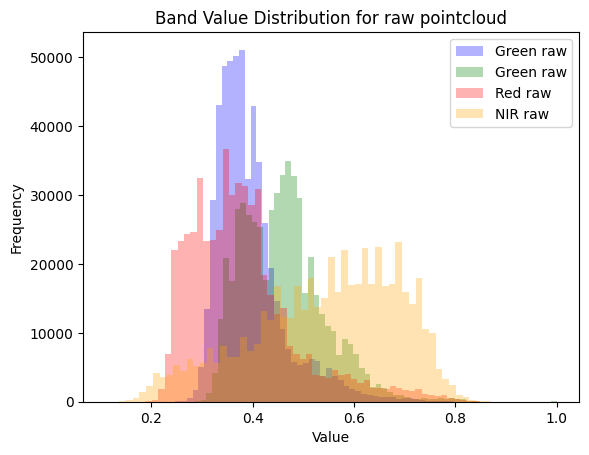

blue band:	max = 0.9804	min = 0.2471
green band:	max = 1.0000	min = 0.2863
red band:	max = 1.0000	min = 0.1882
nir band:	max = 0.9608	min = 0.1098


In [6]:
#debugging for NDVI values being between -.4 and .4 instead of -1 and 1
bins = 64
alpha = .3

plt.hist(blue_raw, bins=bins, alpha=alpha, label='Green raw', color='blue')
plt.hist(green_raw, bins=bins, alpha=alpha, label='Green raw', color='green')
plt.hist(red_raw, bins=bins, alpha=alpha, label='Red raw', color='red')
plt.hist(nir_raw, bins=bins, alpha=alpha, label='NIR raw', color='orange')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Band Value Distribution for raw pointcloud')
plt.legend()
plt.show()

print(f'blue band:\tmax = {blue_raw.max():.4f}\tmin = {blue_raw.min():.4f}')
print(f'green band:\tmax = {green_raw.max():.4f}\tmin = {green_raw.min():.4f}')
print(f'red band:\tmax = {red_raw.max():.4f}\tmin = {red_raw.min():.4f}')
print(f'nir band:\tmax = {nir_raw.max():.4f}\tmin = {nir_raw.min():.4f}')


In [7]:
def subplots_attribute_histograms(attribute_layers: dict, title="Attribute Histograms"):
    """
    Create subplots of histograms for each attribute in attribute_layers.

    Args:
        attribute_layers (dict): Dictionary where keys are attribute names and values are arrays of data.
        title (str): Title for the entire figure.
    """
    max_columns = 3  # Maximum number of histograms per row
    num_attributes = len(attribute_layers)
    num_rows = (num_attributes + max_columns - 1) // max_columns  # Calculate required rows

    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, max_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten to 1D array for easy indexing

    for idx, (name, data) in enumerate(attribute_layers.items()):
        ax = axes[idx]
        ax.hist(data, bins=32)
        ax.set_title(f"{name}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.grid(linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for idx in range(num_attributes, len(axes)):
        axes[idx].axis('off')

    # Add a main title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_histogram(band_values, name='<No Name>'):
    """Plot a histogram of NDVI values."""
    plt.figure(figsize=(10, 6))
    plt.hist(band_values, bins=32)
    plt.title(f"Histogram {name}")
    plt.xlabel("Band Value")
    plt.ylabel("Frequency")
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

    print(f' min value: {min(band_values)}')
    print(f' max value: {max(band_values)}')

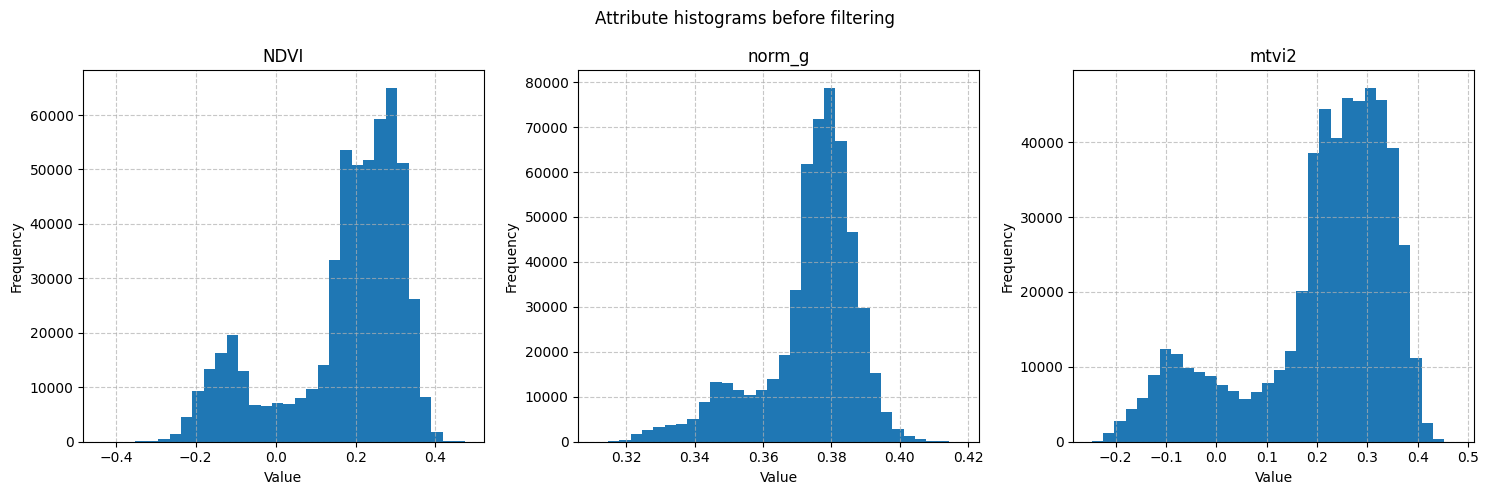

In [8]:
original_attr_of_interest = {
    'NDVI': original_las.ndvi,
    'norm_g': original_las.norm_g,
    'mtvi2': original_las.mtvi2
    }

subplots_attribute_histograms(original_attr_of_interest, title='Attribute histograms before filtering')


In [9]:
# Mapping AHN classification codes to their meanings
AHN_classification_mapping = {
    0: "Created, never classified",
    1: "Unclassified",
    2: "Ground",
    6: "Building",
    9: "Water",
    14: "High tension",
    26: "Civil structure"
}

# Extract classification values from the LAS file
classification_values = original_las.classification

# Print unique classification values and their meanings
unique_values = np.unique(classification_values)
print("Unique Classification Values and Meanings:")
for value in unique_values:
    meaning = AHN_classification_mapping.get(value, "Unknown")  # Handle unknown classifications
    print(f"Class {value}:\t{meaning}")

# Count the occurrences of each classification
counts = Counter(classification_values)

# Sort the classifications by count in descending order
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Display the classification counts in a tabular format
print("\nClassification Counts (Ordered by Frequency):")

# Define column widths for alignment
class_col_width = 10  
meaning_col_width = 25  
count_col_width = 15  

# Print header
print(f"{'Class'.ljust(class_col_width)} {'Meaning'.ljust(meaning_col_width)} {'Points'.rjust(count_col_width)}")
print("-" * (class_col_width + meaning_col_width + count_col_width + 5))

# Print the counts for each classification
for cls, count in sorted_counts:
    meaning = AHN_classification_mapping.get(cls, "Unknown")
    print(f"{str(cls).ljust(class_col_width)} {meaning.ljust(meaning_col_width)} {str(count).rjust(count_col_width)}")


Unique Classification Values and Meanings:
Class 1:	Unclassified
Class 2:	Ground
Class 6:	Building
Class 9:	Water

Classification Counts (Ordered by Frequency):
Class      Meaning                            Points
-------------------------------------------------------
1          Unclassified                       262103
2          Ground                             239680
6          Building                            37182
9          Water                                  31


## Below the filtering of the pointcloud takes place

In [10]:
#create copy of las_original to perform filtering on the copy (called las for simplicity)
las = laspy.LasData(original_las.header)
las.points = original_las.points.copy()

#Filter to keep only Unclassified points
# las = las[las.classification == 1]

#Filter out points with NDVI value under threshold
# ndvi_threshold = 0.0
# las = las[las.ndvi > ndvi_threshold]

#Filter out points with normalised green value under threshold
# norm_g_threshold = 0.36
# las = las[las.norm_g > norm_g_threshold]

#Filter out points with mtvi2 value under threshold
# mtvi2_threshold = 0.32
# las = las[las.mtvi2 > mtvi2_threshold]

#Remove points with single return
las = las[las.number_of_returns > 1]

#Remove last return of all remaining points
las = las[las.return_number != las.number_of_returns]


In [11]:
# Remove outliers using SOR
def remove_outliers(las_data, nb_neighbors=20, std_ratio=2.0):
    # Convert LAS data to Open3D point cloud
    xyz = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)

    # Perform statistical outlier removal
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    
    # Filter the original LAS data
    filtered_las = las_data[ind]
    
    return filtered_las

# After your previous filtering steps:
las = remove_outliers(las, 20, 2.0)

In [12]:
def normalize_array(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [13]:
#Get a normalized colormap for attributes that are not RGB
def apply_colormap(values:np.array, colormap_name="viridis"):
    cmap = plt.get_cmap(colormap_name)
    return cmap(values)[:, :3]  # Extract RGB (ignore alpha)

In [14]:
def labels_list(las):
    return [f"NDVI: {ndvi:.3f}, norm_green: {ng:.3f}, mtvi2: {mtvi2:.3f}"
            for ndvi, ng, mtvi2 in zip(las.ndvi, las.norm_g, las.mtvi2)]
    

def visualize_pcd_filtered_vs_original(las_filtered, las_original):
    # Initialize rerun
    rr.init("Filtered vs Original", spawn=True)
    
    # Get point coordinates for the two pointclouds
    points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
    points_filtered = np.column_stack((las_filtered.x, las_filtered.y, las_filtered.z))

    # Make original pointcloud white
    # colors_original = np.ones((len(points_original), 3))

    # make original pointcloud original RGB values
    colors_original = np.column_stack((normalize_array(las_original.red), 
                                       normalize_array(las_original.green),
                                       normalize_array(las_original.blue)))

    # colors_filtered = apply_colormap(normalize_array(las.mtvi2))

    # #add alpha to filtered points
    # alpha_value = 0.8
    # colors_filtered = np.column_stack((colors_filtered, np.full(colors_filtered.shape[0], alpha_value)))

    # Make filtered pointcloud green
    colors_filtered = np.column_stack(( np.zeros(len(points_filtered)),
                                        np.ones(len(points_filtered)),
                                        np.zeros(len(points_filtered))))



    # Log the original point cloud
    rr.log("original", rr.Points3D( positions=points_original,
                                                colors=colors_original,
                                                radii=.1,
                                                labels= labels_list(las_original)))

    # Log the filtered point cloud
    rr.log("filtered", rr.Points3D( positions=points_filtered,
                                                colors=colors_filtered,
                                                radii=.2, #slightly larger than original for visualization 
                                                labels=labels_list(las_filtered))) 

    print(f"Visualization ready. Run 'rerun' in terminal to view.")


In [15]:
def labels_list(las):
    return [f"NDVI: {ndvi:.3f}, norm_green: {ng:.3f}, mtvi2: {mtvi2:.3f}"
            for ndvi, ng, mtvi2 in zip(las.ndvi, las.norm_g, las.mtvi2)]
    
def visualize_multiple_pcd_attributes(las_filtered, las_original, attributes_dict):
    # Initialize rerun
    rr.init("Multiple attribute viewer", spawn=True)
    
    # Get point coordinates for the two pointclouds
    points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
    points_filtered = np.column_stack((las_filtered.x, las_filtered.y, las_filtered.z))
  

    # Original point cloud with RGB colors
    colors_original = np.column_stack((
        normalize_array(las_original.red),
        normalize_array(las_original.green),
        normalize_array(las_original.blue)
    ))

    # Log the original point cloud
    rr.log("original_point_cloud", rr.Points3D(
        positions=points_original,
        colors=colors_original,
        radii=0.1,
        labels=labels_list(las_original)
    ))

    # Filtered point cloud with dynamic attributes
    for name, values in attributes_dict.items():
        normalized_values = normalize_array(values)
        attribute_colors = apply_colormap(normalized_values)
        # #add alpha to filtered points
        # alpha_value = 1
        # attribute_colors = np.column_stack((attribute_colors, np.full(attribute_colors.shape[0], alpha_value)))
        
        # Log the filtered point cloud with the specific attribute
        rr.log(f"{name}", rr.Points3D(
            positions=points_filtered,
            colors=attribute_colors,
            radii=0.2,  # Slightly larger for visualization
            labels=labels_list(las_filtered)
        ))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")

Visualization ready. Run 'rerun' in terminal to view.
Visualization ready. Run 'rerun' in terminal to view.


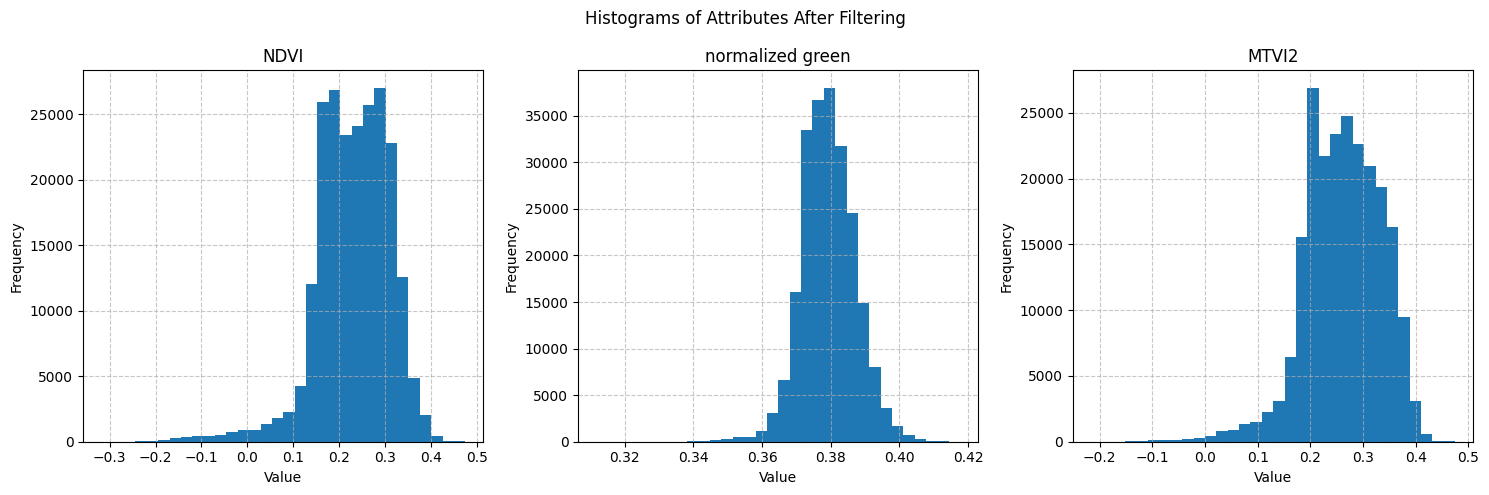

In [16]:
# use function to visualise attributes with a colormap in separate layers
# within the rerun viewer

filtered_attr_of_interest = {
    'NDVI': las.ndvi,
    'normalized green' : las.norm_g,
    'MTVI2' : las.mtvi2
}

# Add layer for before and after filtering
visualize_pcd_filtered_vs_original(las, original_las)

#add separate layers to rerun with colormap
visualize_multiple_pcd_attributes(las, original_las, filtered_attr_of_interest)



# Plot histograms for all attributes
subplots_attribute_histograms(filtered_attr_of_interest, title="Histograms of Attributes After Filtering")


In [17]:
print(len(las))

222529


In [18]:
# save the filtered point cloud to laz format
output_las = os.path.join('..', 'data', "pcd_wilhelmina_park", "whm_001_filtered.laz")
las.write(output_las)
print(f"las file saved to {output_las}")

# save the filtered point cloud to xyz format
xyz_data = np.vstack((las.X, las.Y, las.Z)).T
output_xyz = os.path.join('..', 'data', "pcd_wilhelmina_park", "whm_001_filtered.xyz")
np.savetxt(output_xyz, xyz_data, fmt="%.3f")
print(f"XYZ file saved to {output_xyz}")

las file saved to ..\data\pcd_wilhelmina_park\whm_001_filtered.laz
XYZ file saved to ..\data\pcd_wilhelmina_park\whm_001_filtered.xyz


In [23]:
# Retrieve scaling factors and offsets from the LAS header
scale = las.header.scales  # [scale_x, scale_y, scale_z]
offset = las.header.offsets  # [offset_x, offset_y, offset_z]

# Convert from scaled integers to real-world coordinates
xyz_data = np.vstack((las.X * scale[0] + offset[0],
                       las.Y * scale[1] + offset[1],
                       las.Z * scale[2] + offset[2])).T

print(f"scale: {scale}")
print(f"offset: {offset}")

# Save with correct world coordinates
output_xyz = os.path.join('..', 'data', "pcd_wilhelmina_park", "whm_001_filtered_crs.xyz")
np.savetxt(output_xyz, xyz_data, fmt="%.6f")  # Higher precision for better accuracy
print(f"XYZ file saved to {output_xyz}")


scale: [0.001 0.001 0.001]
offset: [ 82980. 446230.      0.]
XYZ file saved to ..\data\pcd_wilhelmina_park\whm_001_filtered_crs.xyz


# Continue with Open3D to calculate and output alpha shape

In [20]:
# # Load points
# points = np.vstack((las.x, las.y, las.z)).transpose()
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points)

# # Optional: Downsample the point cloud if it's too large
# # voxel_size = 0.05  # Adjust this value as needed
# # pcd = pcd.voxel_down_sample(voxel_size)

In [21]:
# # Cluster the point cloud using DBSCAN
# eps = 1.5  # Adjust this value based on your data
# min_points = 10  # Minimum number of points to form a cluster
# labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))

# # Get the number of clusters (excluding noise, which is labeled as -1)
# max_label = labels.max()
# print(f"Number of clusters: {max_label + 1}")


In [22]:
# # DEBUG: Visualize a specific cluster (e.g., cluster 0)
# cluster_points = pcd.select_by_index(np.where(labels == 500)[0])
# o3d.visualization.draw_geometries([cluster_points])